>Igor Sorochan DSU-31

# Image quantization using various clustering algorithms


### Loading the sufficient libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
try:
    import cv2
except:
    !python -m pip install opencv-python -q
    import cv2
try:
    import skimage
except:
    !python -m pip install -U scikit-image
    import skimage

    
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, AffinityPropagation, SpectralClustering, MeanShift
from skimage.metrics import structural_similarity  as ssim

#### Define draw function

In [2]:
def draw_picture(image, title, bgr=False) -> None:
    """Reverse the order of colors if the image is in BGR format if bgr=True.
    Draws the picture with the given title.
    """
    if bgr:
        b, g, r = cv2.split(image)          # by default cv2 reads images in BGR format
        image = cv2.merge([r, g, b])    # that's why we need to change the order of colors
    # plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(image)
    plt.title(title)

    return 

#### Sample image

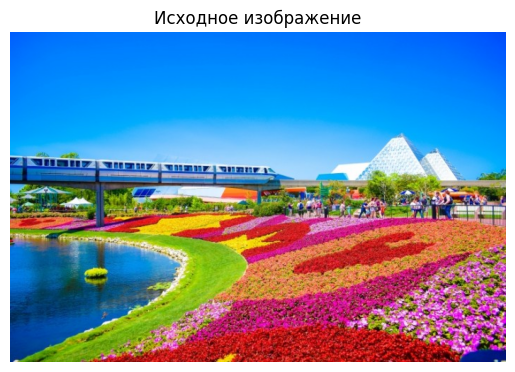

In [32]:
original_image = cv2.imread('../../data/YArkaya-klumba-Bright-flower-bed-6000x4000-700x466.jpg')
draw_picture(original_image, 'Исходное изображение', bgr=True)

In [33]:
type(original_image), original_image.dtype, original_image.shape    # (height, width, channels)

(numpy.ndarray, dtype('uint8'), (466, 700, 3))

In [35]:
h,w,c = original_image.shape     # save height, width and channels of the original image
img_2d = original_image.reshape((-1, 3))  # reshape the image to 2D array
results ={}

In [36]:
img_2d.shape, img_2d.dtype

((326200, 3), dtype('uint8'))

## K-means

uint8 uint8 (466, 700, 3) (466, 700, 3) 0.2253029969424253 0.2
uint8 uint8 (466, 700, 3) (466, 700, 3) 0.31976524616300106 0.5
uint8 uint8 (466, 700, 3) (466, 700, 3) 0.3895181542411797 0.8
uint8 uint8 (466, 700, 3) (466, 700, 3) 0.4211211399785457 1.3


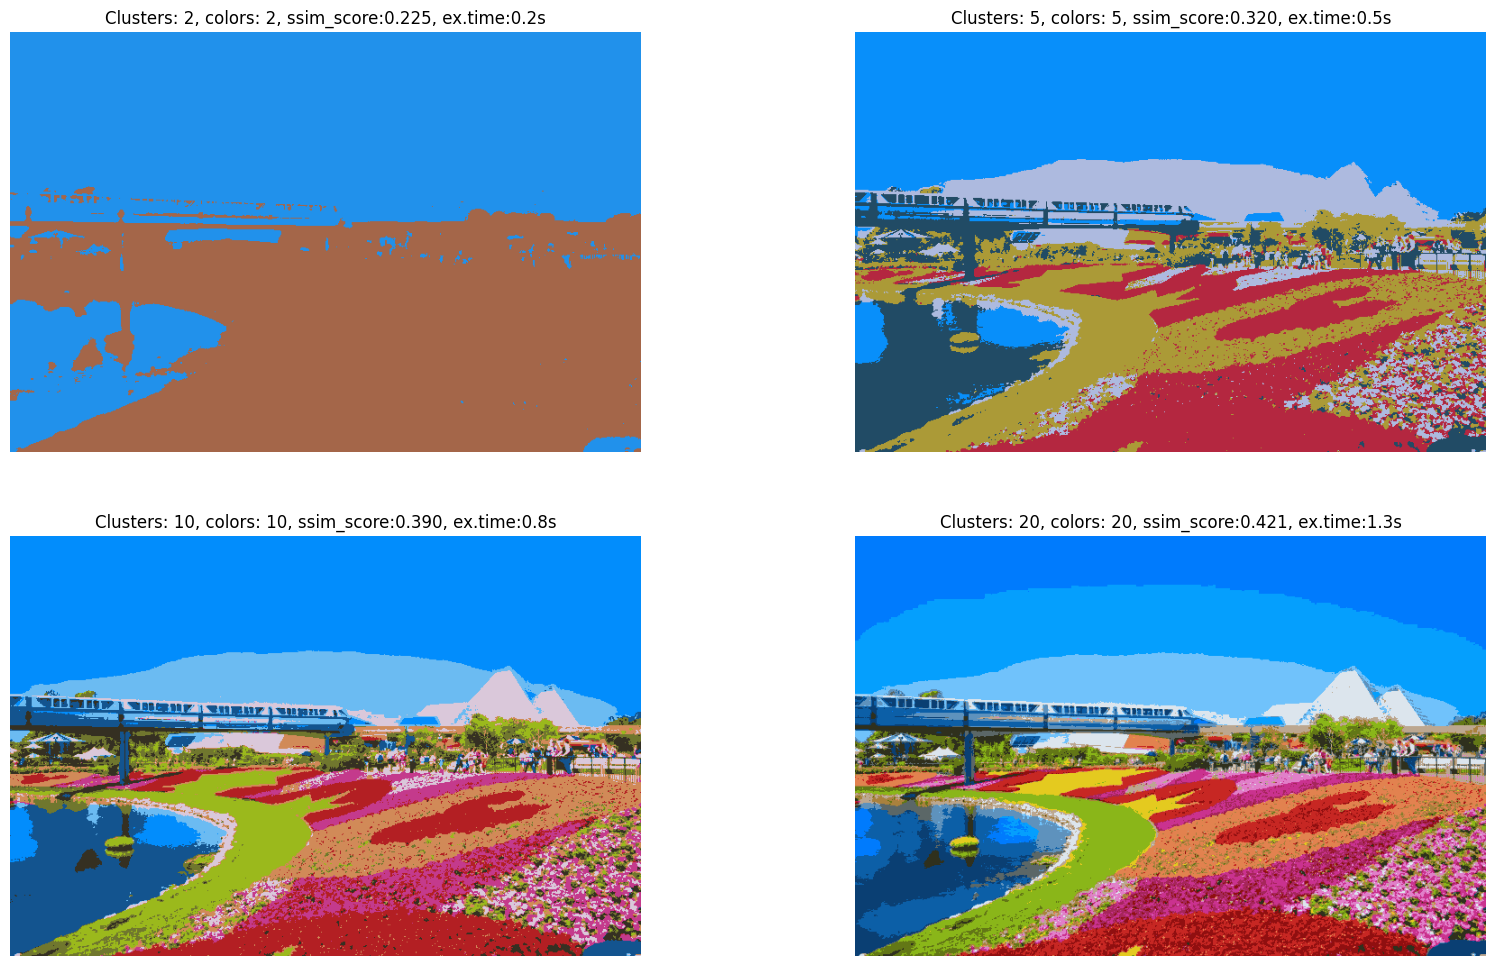

In [37]:
start_time = time.time()  # Get the current time

plt.figure(figsize=(20, 12))
for i, cl in enumerate([2, 5, 10, 20]):
    clusterer = KMeans(n_clusters=cl, random_state=42,
                       n_init='auto')   # create KMeans object
    # fit and predict clusters for the image, returns 1D array with cluster labels
    cluster_labels = clusterer.fit_predict(img_2d)
    # get cluster centers (actually colors) and round them to integers (RGB)
    rgb_cols = clusterer.cluster_centers_.round(0).astype(np.uint8)

    # reshape the image again to 3D array
    temp_img = np.reshape(rgb_cols[cluster_labels], (h, w, c))
    temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
    ssim_score = ssim(original_image,  temp_img,  channel_axis=2, multichannel=True)
    print(original_image.dtype, temp_img.dtype,
          original_image.shape, temp_img.shape, ssim_score,round(time.time() - start_time,1))
    
    # plot the quantized image
    plt.subplot(2, 2, i+1)
    plt.axis('off')
    plt.imshow(temp_img)
    plt.title(
        f'Clusters: {cl}, colors: {len(np.unique(cluster_labels))}, ssim_score:{ssim_score:.3f}, ex.time:{round(time.time() - start_time,1)}s')

    results['KMeans_'+str(i)] = [cl,
                                 len(np.unique(cluster_labels)), ssim_score, round(time.time() - start_time,1), (w, h)]
plt.show()


## DBSCAN

As many clustering algorithms do not have functionality to find the center of clusters under the hood (as K-means does),  
we need to find them ourseves:  

In [8]:
def map_labels2colors(cluster_labels: np.ndarray, rgb_array: np.ndarray, h: int, w: int, c: int) -> np.ndarray:
    ''' Mapping cluster labels to their corresponding mean RGB values.
    Cluster_labels and rgb_array must have the same length.
    :param cluster_labels: 1D array with cluster labels
    :param rgb_array: 2D array with RGB values
    :param h: height of the image
    :param w: width of the image
    :param c: number of channels
    :return: 3D array with colored clusters'''
    # find unique cluster labels 
    unique_clusters = np.unique(cluster_labels)
    # initialize array for mean RGB values
    mean_rgb_values = np.zeros((len(unique_clusters), c))
    for i, cluster_label in enumerate(unique_clusters):
        # if cluster_label == -1:
        #     mean_rgb_values[i] = [0, 0, 0]  # assign black color to noise cluster (dbscan)
        # else:
            # aggregate and find mean RGB values for each cluster:
            # 1. groupby: cluster_labels == cluster_label - boolean mask with Trues for pixels with cluster_label
            # 2. calculate mean among selected rows (the pixels from rgb_array that belong to the specified cluster label)
        mean_rgb_values[i] = np.mean(rgb_array[cluster_labels == cluster_label], axis=0)  
        
    # round mean RGB values to integers
    # cast to np.uint8 to prevent skimage from throwing a warning of data type mismatch between imgages arrays
    mean_rgb_values = np.round(mean_rgb_values).astype(np.uint8)        

    # map cluster labels to their corresponding mean RGB values,  mapping: labels <-> mean RGB values
    cluster_to_rgb = dict(zip(unique_clusters, mean_rgb_values))
    if -1 in unique_clusters:           
        cluster_to_rgb[-1] = [0, 0, 0]  # assign black color to noise cluster (dbscan)

    # map each pixel's cluster label to its corresponding RGB value
    output_array = np.array([cluster_to_rgb[label] for label in cluster_labels], dtype=np.uint8)

    # reshape the image to 3D array and convert from BGR to RGB (reverse order of 3rd dimension)
    output_array = output_array.reshape(h, w, c)[:, :, ::-1]    

    return output_array
    
    # INITIAL CODE WITH PANDAS
    # df1 = pd.DataFrame(cluster_labels, columns=['cluster'])             # create dataframe with cluster labels
    # df=pd.DataFrame(img_2d, columns=['R', 'G', 'B'])                    # create dataframe with RGB values
    # dff=pd.concat([df, df1], axis=1)                                    # concatenate two dataframes
    # df_cluster = dff.groupby('cluster').mean().round(0).astype(int)     # group by cluster and calculate mean values for each cluster
    # df_cluster = df_cluster.reset_index()                               # reset index

    # colors = df_cluster.to_dict('index')                                # convert dataframe to dictionary with index as key and RGB values as MEAN values
    # output_array = np.ones((len(cluster_labels), 3), dtype=int)
    # cnt=0
    # for j, elem in enumerate(cluster_labels): 
    #     if elem == -1:                                                  # if cluster label is -1 (noise) then assign black color
    #         output_array[j] = [0, 0, 0]
    #     else:
    #         output_array[j] = [colors[elem+1]['R'], colors[elem+1]['G'], colors[elem+1]['B']]

uint8 uint8 (466, 700, 3) (466, 700, 3) 0.04590438488935897 3.6
uint8 uint8 (466, 700, 3) (466, 700, 3) 0.12521907434211352 25.6
uint8 uint8 (466, 700, 3) (466, 700, 3) 0.16615692346642638 103.3
uint8 uint8 (466, 700, 3) (466, 700, 3) 0.22332931035758755 295.1


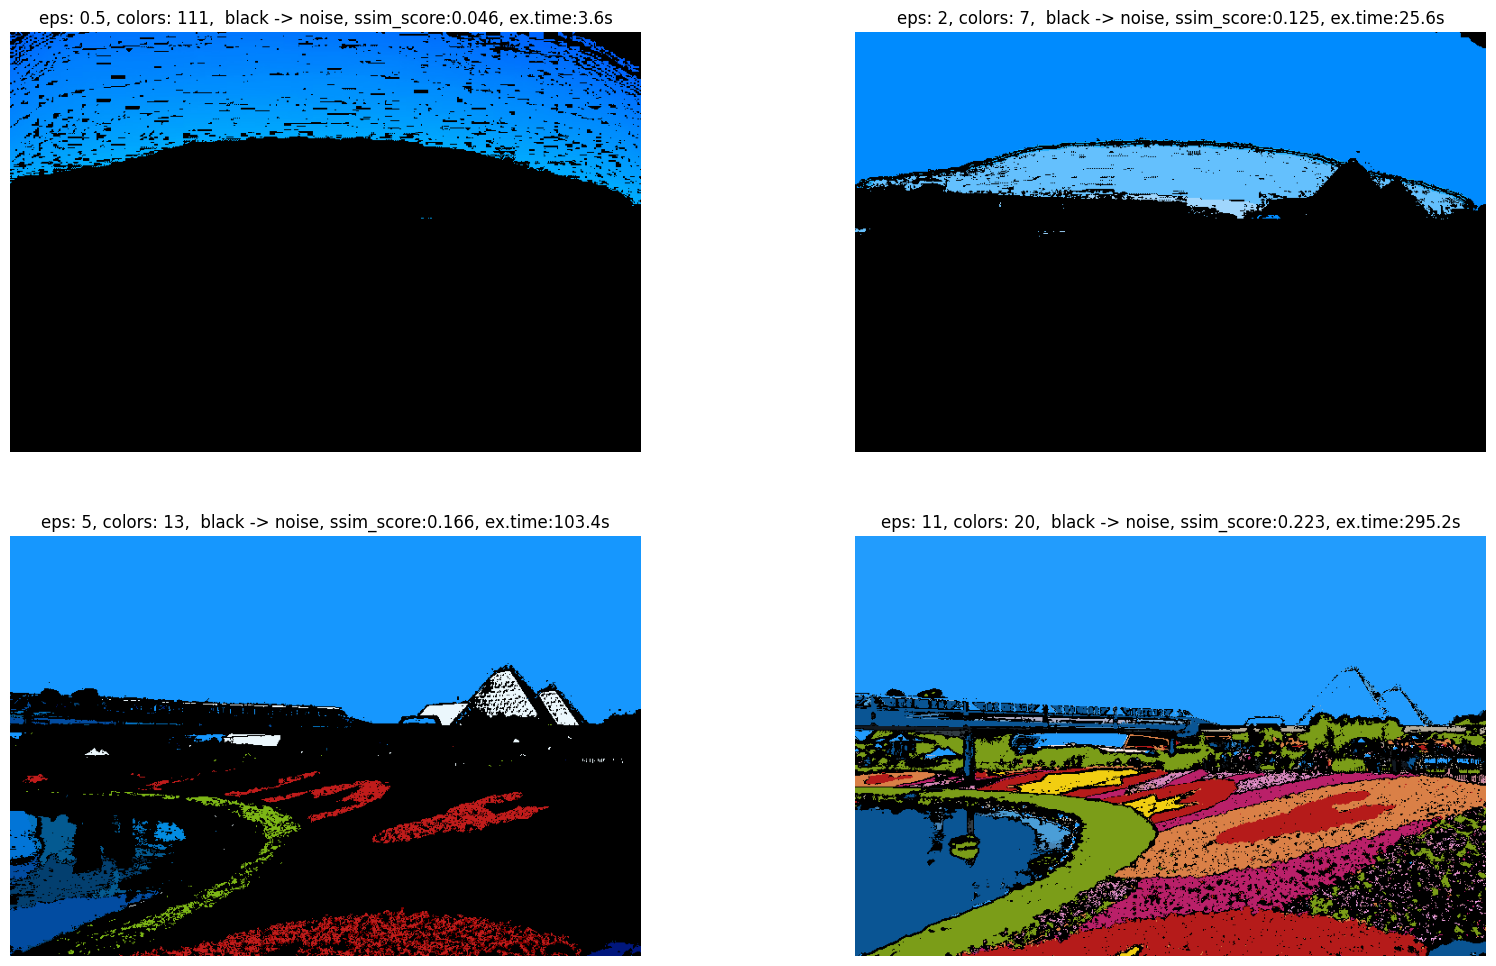

In [9]:
start_time = time.time()  # Get the current time
plt.figure(figsize=(20, 12))
for i, eps in enumerate([0.5, 2, 5, 11]):
    clusterer = DBSCAN(eps=eps, min_samples=200)
    # fit and predict clusters for the image
    cluster_labels = clusterer.fit_predict(img_2d)

    temp_img = map_labels2colors(cluster_labels, img_2d, h, w, c)
    ssim_score = ssim(original_image,  temp_img,
                      channel_axis=2, multichannel=True)
    print(original_image.dtype, temp_img.dtype, original_image.shape,
          temp_img.shape, ssim_score, round(time.time() - start_time, 1))

    plt.subplot(2, 2, i+1)
    plt.axis('off')
    plt.imshow(temp_img)
    plt.title(f'eps: {eps}, colors: {len(np.unique(cluster_labels))},  black -> noise, ssim_score:{ssim_score:.3f}, ex.time:{round(time.time() - start_time,1)}s')

    results['DBSCAN_'+str(i)] = [eps, len(np.unique(cluster_labels)),
                                 ssim_score, round(time.time() - start_time, 1), (w, h)]
plt.show()


### AgglomerativeClustering

AgglomerativeClustering struggles with large datasets throws MemoryError and kills python kernel.  
That's why we'll use a smaller image for this algorithm.

(30000, 3)


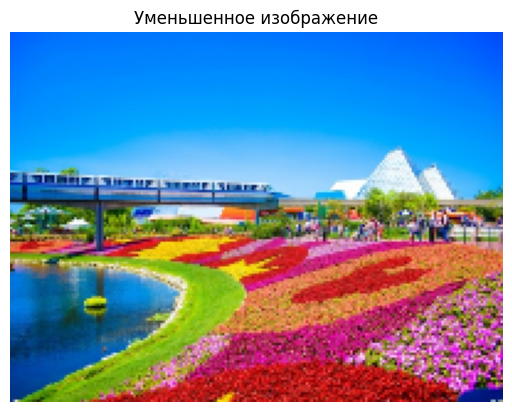

In [10]:
resized_img = cv2.resize(original_image, (200, 150))
resized_2d = resized_img.reshape(-1, 3)
print(resized_2d.shape)
draw_picture(resized_img, 'Уменьшенное изображение', bgr=True)
h, w, c = resized_img.shape


uint8 uint8 (150, 200, 3) (150, 200, 3) 0.18223604966278137 29.9
uint8 uint8 (150, 200, 3) (150, 200, 3) 0.28304854813304514 69.9
uint8 uint8 (150, 200, 3) (150, 200, 3) 0.3474355006909937 98.3
uint8 uint8 (150, 200, 3) (150, 200, 3) 0.38361524899762617 123.4


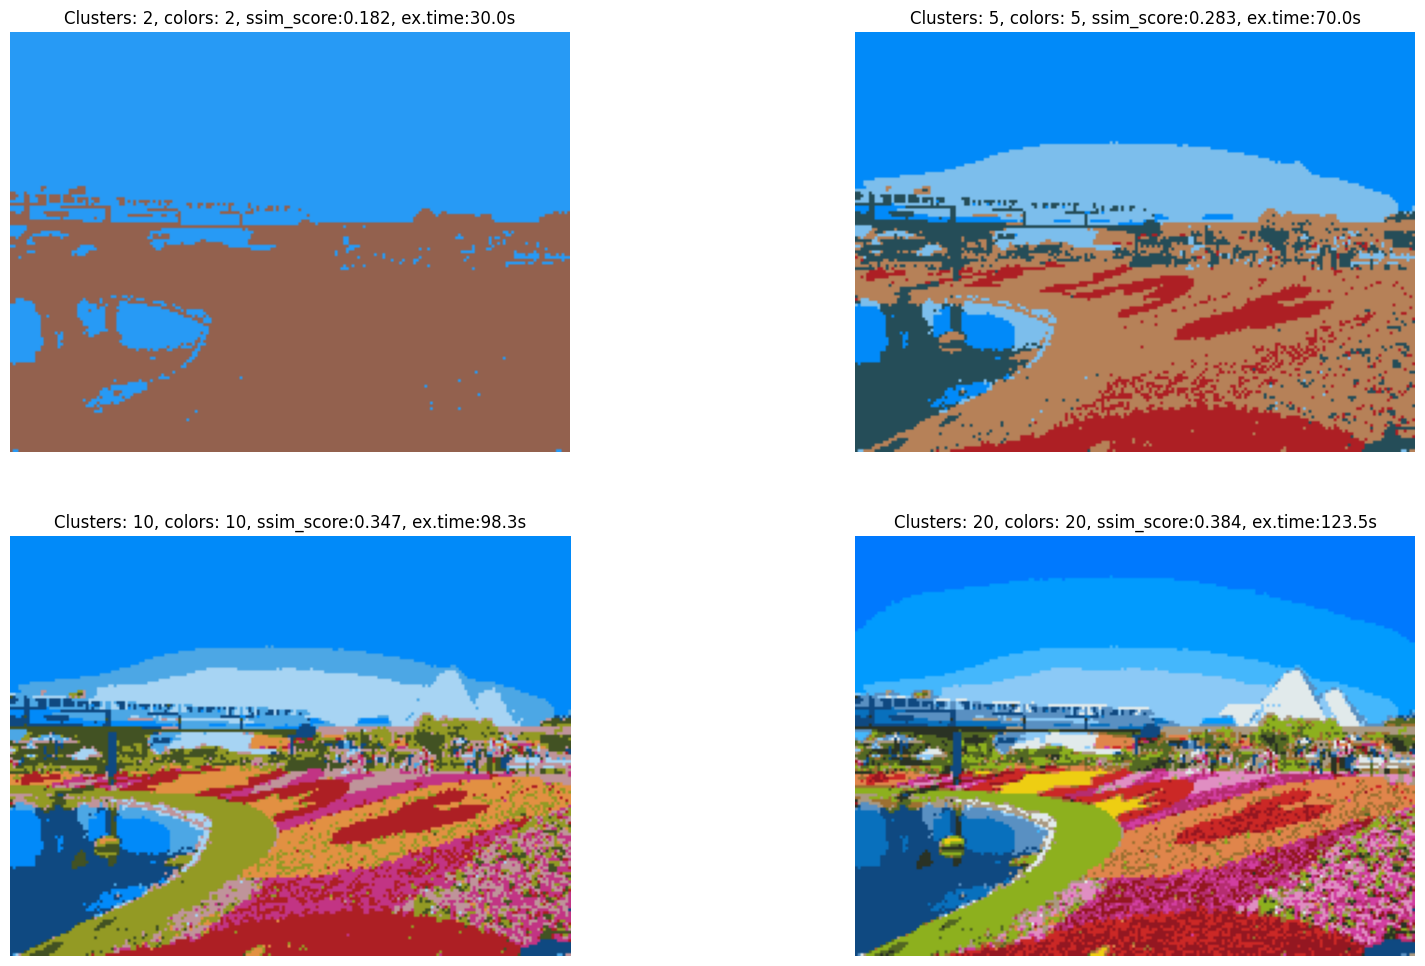

In [11]:
start_time = time.time()  # Get the current time
plt.figure(figsize=(20, 12))
for i, n_clusters in enumerate([2, 5, 10, 20]):

    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(resized_2d)

    temp_img = map_labels2colors(cluster_labels, resized_2d, h, w, c)

    ssim_score = ssim(resized_img,  temp_img,
                      channel_axis=2, multichannel=True)
    print(resized_img.dtype, temp_img.dtype, resized_img.shape,
          temp_img.shape, ssim_score, round(time.time() - start_time, 1))

    # plot the quantized image
    plt.subplot(2, 2, i+1)
    plt.axis('off')
    plt.imshow(temp_img)
    plt.title(
        f'Clusters: {n_clusters}, colors: {len(np.unique(cluster_labels))}, ssim_score:{ssim_score:.3f}, ex.time:{round(time.time() - start_time,1)}s')
    results['AgglomerativeClustering_'+str(i)] = [n_clusters, len(
        np.unique(cluster_labels)), ssim_score, round(time.time() - start_time, 1), (w, h)]
plt.show()

### Affinity propogation

(8000, 3)


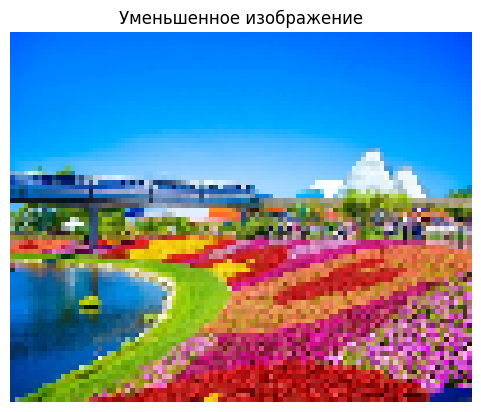

In [12]:
resized_img = cv2.resize(original_image, (100, 80))
resized_2d = resized_img.reshape(-1, 3)
print(resized_2d.shape)
draw_picture(resized_img, 'Уменьшенное изображение', bgr=True)
h, w, c = resized_img.shape


/Users/velo1/SynologyDrive/GIT_syno/Mac/Netology/.venv/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


uint8 uint8 (80, 100, 3) (80, 100, 3) 0.437867596189526 185.9


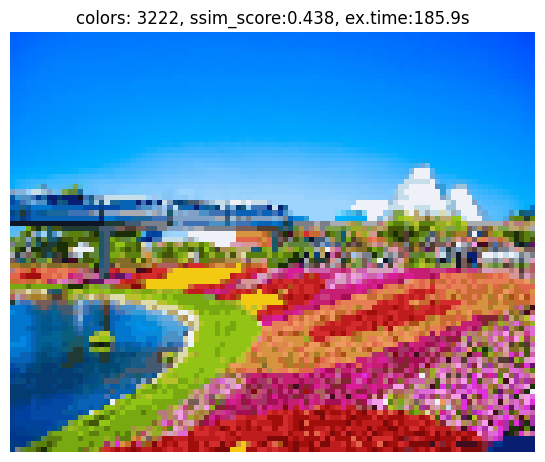

In [13]:
start_time = time.time()
plt.figure(figsize=(20, 12))
# for i, n_clusters in enumerate([2, 5, 10, 20]):
clusterer = AffinityPropagation()
cluster_labels = clusterer.fit_predict(resized_2d)
rgb_cols = clusterer.cluster_centers_.round(0).astype(np.uint8)
temp_img = np.reshape(rgb_cols[cluster_labels], (h, w, c))
temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
ssim_score = ssim(resized_img,  temp_img,
                  channel_axis=2, multichannel=True)
print(resized_img.dtype, temp_img.dtype,
      resized_img.shape, temp_img.shape, ssim_score, round(time.time() - start_time, 1))

# plot the quantized image
plt.subplot(2, 2, i+1)
plt.axis('off')
plt.imshow(temp_img)
plt.title(
    f'colors: {len(np.unique(cluster_labels))}, ssim_score:{ssim_score:.3f}, ex.time:{round(time.time() - start_time,1)}s')

results['KMeans_'+str(1)] = [cl,
                             len(np.unique(cluster_labels)), ssim_score, round(time.time() - start_time, 1), (w, h)]

plt.show()


### Mean shift

uint8 uint8 (80, 100, 3) (80, 100, 3) -0.005044463883273079 10.1


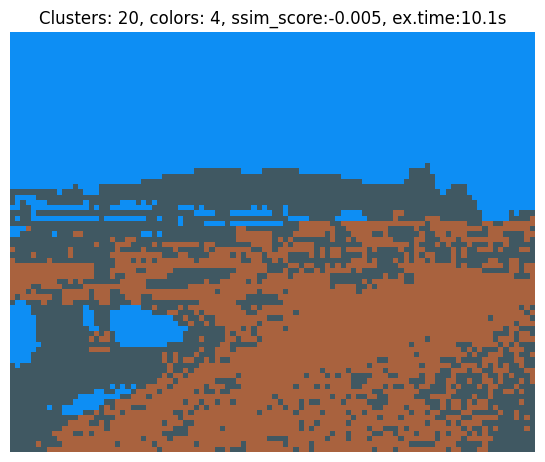

In [14]:
start_time = time.time()  
plt.figure(figsize=(20, 12))
clusterer = MeanShift(cluster_all=False, n_jobs=-1)   
cluster_labels=clusterer.fit_predict(resized_2d)
rgb_cols = clusterer.cluster_centers_.round(0).astype(np.uint8)
temp_img = np.reshape(rgb_cols[cluster_labels], (h, w, c))
temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
ssim_score = ssim(resized_img,  temp_img,
                    channel_axis=2, multichannel=True)
print(resized_img.dtype, temp_img.dtype, resized_img.shape,
        temp_img.shape, ssim_score, round(time.time() - start_time, 1))

# plot the quantized image
plt.subplot(2, 2, i+1)
plt.axis('off')
plt.imshow(temp_img)
plt.title(
    f'Clusters: {n_clusters}, colors: {len(np.unique(cluster_labels))}, ssim_score:{ssim_score:.3f}, ex.time:{round(time.time() - start_time,1)}s')
results['MeanShift_'+str(i)] = [n_clusters, len(
    np.unique(cluster_labels)), ssim_score, round(time.time() - start_time, 1), (w, h)]
plt.show()


## Main takeaways:

In [38]:
df_results = pd.DataFrame(
    results, index=['Clusters / eps', 'Colors', 'SSIM', 'time','w * h']).T
df_results['performance Mpixels/s'] = df_results.apply(
    lambda x: x['w * h'][0]*x['w * h'][1], axis=1)/df_results['time']/1e6
df_results.sort_values(by=['SSIM', 'Colors', 'time'], ascending=False).style.format(
    precision=3).background_gradient(subset=['SSIM', "time", 'performance Mpixels/s'], cmap='Blues')


,Clusters / eps,Colors,SSIM,time,w * h,performance Mpixels/s
KMeans_3,20,20,0.421,1.300,"(700, 466)",0.251
KMeans_2,10,10,0.390,0.800,"(700, 466)",0.408
KMeans_1,5,5,0.320,0.500,"(700, 466)",0.652
KMeans_0,2,2,0.225,0.200,"(700, 466)",1.631


`KMeans` is the one and only leader for this type of problems.  
It performed with highest metrics and significantly less execution time.  
In addition I've tried Spectralclustering but it was a way too slow. 